Note that the magnet distance was changed from 38 mm to 21 mm before this measurement, but the temperature was not brought above the niobium critical temperature until later.

In [1]:
%matplotlib inline

In [2]:
from kid_readout.measurement.io import nc

In [3]:
ncf = nc.NCFile('/data/detectors/2016-06-11_020411_sweep_stream.nc')

In [49]:
print(ncf.metadata.script_code)

"""
Measure one resonator per LO frequency. Since each measurement has only one channel, record SingleSweepStreams.
"""
import time

import numpy as np
try:
    from tqdm import tqdm as progress
except ImportError:
    progress = list

from kid_readout.roach import hardware_tools, analog
from kid_readout.measurement import acquire, basic
from kid_readout.equipment import hardware
from kid_readout.settings import CRYOSTAT
if CRYOSTAT.lower() == 'hpd':
    from kid_readout.equipment import hpd_temps as temps
elif CRYOSTAT.lower() == 'starcryo':
    from kid_readout.equipment import starcryo_temps as temps
else:
    raise ValueError("Unknown cryostat: {}".format(repr(CRYOSTAT)))

# Parameters
f0_MHz = np.array([2432, 3488, 3629, 3800])
num_offsets = 100
span_MHz = 10
minimum_MHz = 10
round_to_MHz = 2
lo_MHz = round_to_MHz * np.round((f0_MHz - span_MHz / 2 - minimum_MHz) / round_to_MHz)
offsets_MHz = np.linspace(minimum_MHz, minimum_MHz + span_MHz, num_offsets)
num_tone_samples = 2**19
swe

In [4]:
ss = [ncf.read(name) for name in ncf.node_names()]

In [5]:
[s.sweep.resonator.Q_i for s in ss]

[2152.6326543065529, 35664.03928025996, 19515.062869656809, 4248.9156657952644]

In [7]:
[s.sweep.resonator.Q_e_real for s in ss]

[1850.2357742423776,
 105657.54184294314,
 17894.537743799137,
 1654.1259503267802]

In [46]:
[s.sweep.resonator.Q_e_imag for s in ss]

[1033.96901483275, 31174.547687748447, 8649.7111549861729, -1859.3204196691513]

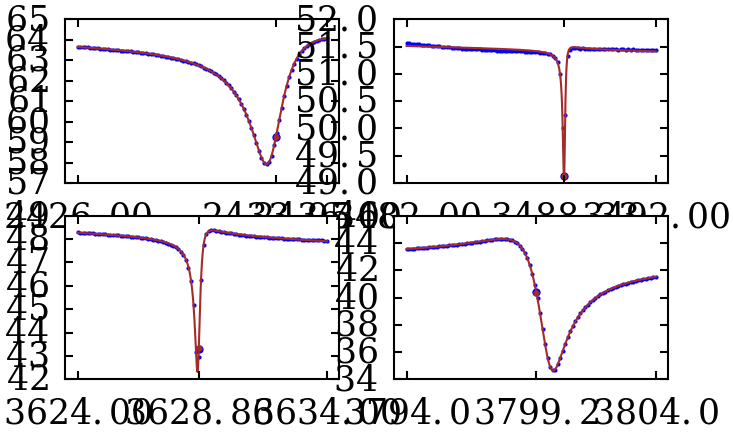

In [29]:
fig, axes = plt.subplots(2, 2)

plt.rcParams['figure.subplot.hspace'] = 0.3
plt.rcParams['figure.subplot.wspace'] = 0.3

for s, ax in zip(ss, axes.flatten()):
    f_scale = 1e-6
    f_min = s.sweep.frequency.min()
    f_max = s.sweep.frequency.max()

    f_model = np.linspace(f_min, f_max, 1000)
    s21_model = s.sweep.resonator.model.eval(params=s.sweep.resonator.current_params, f=f_model)
    f_r = s.sweep.resonator.f_0
    s21_r = s.sweep.resonator.model.eval(params=s.sweep.resonator.current_params, f=f_r)
    ax.plot(f_scale * s.sweep.frequency, 20 * np.log10(np.abs(s.sweep.s21_point)), '.b', markersize=2)
    ax.plot(f_scale * s.stream.frequency, 20 * np.log10(np.abs(s.stream.s21_point)), '.b', markersize=4)
    ax.plot(f_scale * f_model, 20 * np.log10(np.abs(s21_model)), '-', color='brown')
    ax.plot(f_scale * f_r, 20 * np.log10(np.abs(s21_r)), '.', color='brown', markersize=3)

    f_span = f_max - f_min
    ax.set_xlim(f_scale * (f_min - 0.05 * f_span), f_scale * (f_max + 0.05 * f_span))
    ax.set_xticks(f_scale * np.array([f_min, f_r, f_max]))

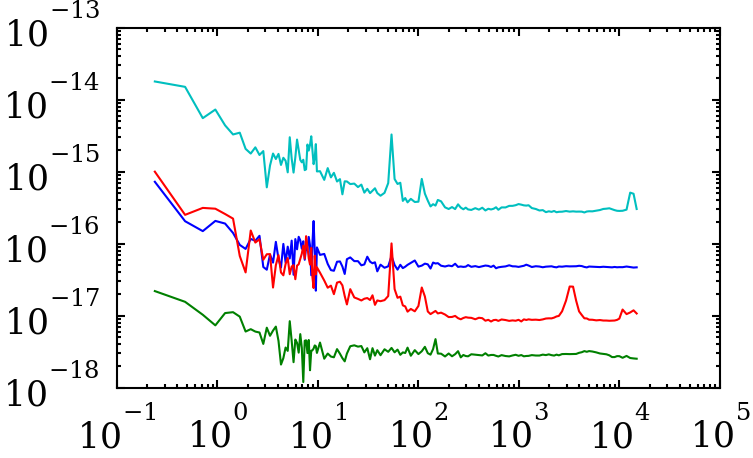

In [45]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

for s in ss:
    s.set_q_and_x(deglitch=False)
    ax.plot(s.S_frequency, s.S_xx)

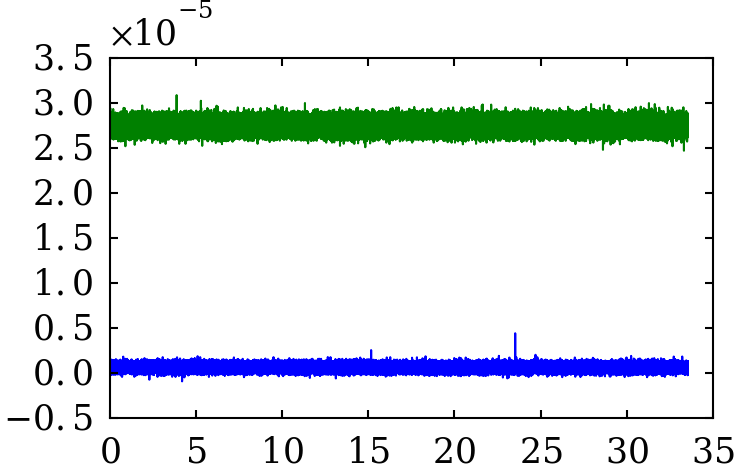

In [32]:
s = ss[1]
s.set_q_and_x(deglitch=False)

fig, ax = plt.subplots()
ax.plot(s.stream.sample_time, s.x)
ax.plot(s.stream.sample_time, s.q)

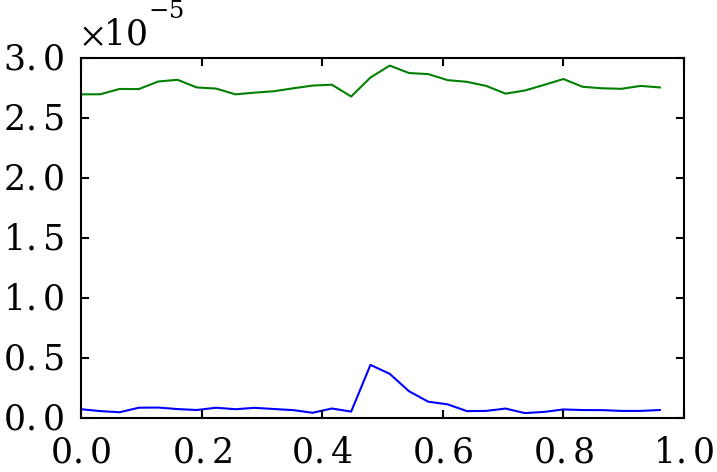

In [44]:
s1g = s.epochs(s.stream.epoch + 23.53, s.stream.epoch + 23.531)
s1g.set_q_and_x(deglitch=False)
fig, ax = plt.subplots()
ax.plot(1e3 * s1g.stream.sample_time, s1g.x)
ax.plot(1e3 * s1g.stream.sample_time, s1g.q)